# Harry and Matty - CMPINF0010 Final Project

## Introduction + Metric

While determining the criteria for the "best" neighborhood in Pittsburgh we came up with many ideas from overall saftey to best area to raise children however we eventually decided upon the best place to hide a body. Now this may sound quite far fetched, but one day you may find yourself in a situation that would require you to take a few notes from this presentation so stay tuned. In determing what neighborhood would be the best fitted to hide a body, we decided to watch a few mafia movies and we found that remote areas lacking high vehicle traffic, lacking security cameras, and lacking arrest to population ratio. This became the metric for our research into finding the "best" neighborhood in Pittsburgh. To begin this research we decided upon a few data sets recording a few different things. The first data set we chose recorded the number of cars that passed through different intersections around Pittsburgh. The next data set we chose recorded the number of security camera in use signs around different locations in Pittsburgh. And the last data set we decided upon was arrest data which we paired with population data to find average arrests per capita in each neighborhood.

First lets import everything that we will need:

In [2]:
import pandas as pd
import math
import numpy as np
%matplotlib inline
import geopandas
import matplotlib.pyplot as plt
from pandas import concat

And then load up our first data set and sort it as needed. Our first data set is using traffic data across Pittsburgh. Some neighborhoods have multiple traffic counters while others have less, so we add up all the traffic counters traffic counts and then divide by the amount of counters for each neighborhood. This first graph shows us the neighborhoods with the highest traffic counts.

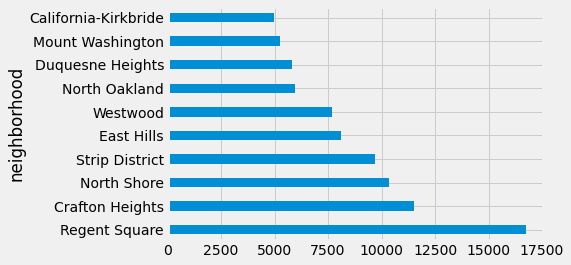

In [3]:
traffic = pd.read_csv("trafficCount.csv", usecols = ["neighborhood", "average_daily_car_traffic"])
traffic = traffic.dropna()
trafficNums = traffic.groupby("neighborhood").size()
num_traffic = traffic.groupby("neighborhood").sum()['average_daily_car_traffic']

for i in range(len(num_traffic)):
    num_traffic[i] = num_traffic[i]/trafficNums[i]
    
plt.style.use('fivethirtyeight')

num_traffic.sort_values(ascending=False)[:10].plot.barh(width = 0.4)

If we are trying to hide a body we want somewhere with less traffic, so lets look at the lowest traffic counts instead.

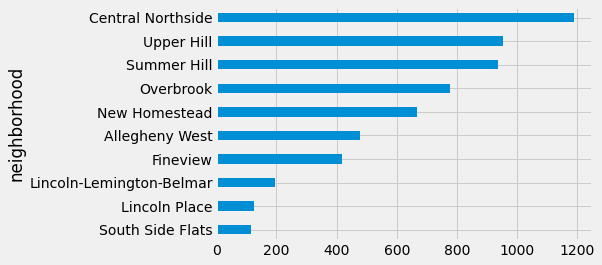

In [4]:
num_traffic.sort_values(ascending=True)[:10].plot.barh(width = 0.4)

And then we can visualize the data to get a good view of where to stay away from.

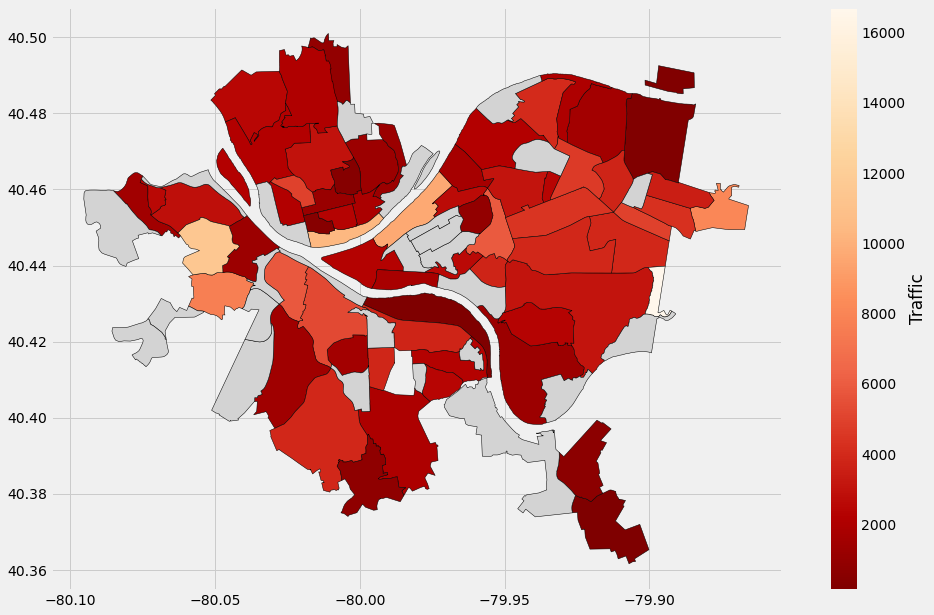

In [5]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
traffic_map = neighborhoods.merge(num_traffic, how='left', left_on='hood', right_on='neighborhood')
traffic_map.plot(column='average_daily_car_traffic', cmap='OrRd_r', edgecolor="black", legend=True,
                 legend_kwds={'label': "Traffic"},figsize=(15, 10), missing_kwds={"color": "lightgrey"})

Next we are gonna look distance to pittsburgh police stations, becuase we dont want to hide a body anywhere near police stations. This data set shows all the major police stations in Pittsburgh.

In [6]:
police = pd.read_csv("police.csv", usecols = ["latitude", "longitude", "type", "name"])
police = police[police["type"]=="Police"][1:]
new_police_station = pd.DataFrame({"latitude": [40.44215], "longitude": [-80.03218], "type": ["Police"], "name": ["Police Zone 06"]})
police = concat([police, new_police_station], ignore_index=True)
police.head(10)

,name,type,latitude,longitude
0,Police Headquarters,Police,40.450594,-80.021420
1,Police Zone 01,Police,40.457007,-80.016092
2,Police Zone 02,Police,40.443584,-79.979972
3,Police Zone 03,Police,40.421670,-79.992496
4,Police Zone 04 Firehouse 18,Police,40.441413,-79.921139
5,Police Zone 05,Police,40.474208,-79.909148
6,Police Zone 2 Substation,Police,40.441812,-80.001663
7,Police Zone 06,Police,40.442150,-80.032180


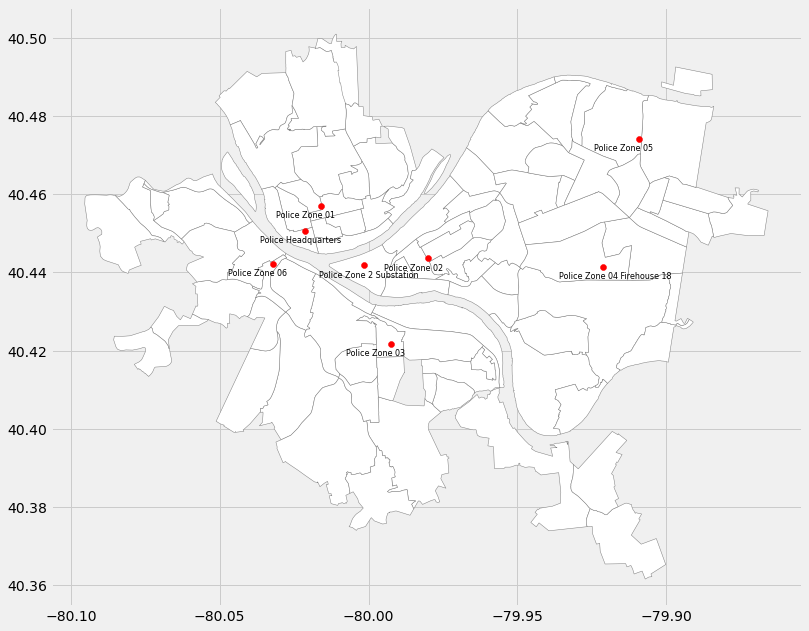

In [7]:
fig, ax = plt.subplots(figsize = (12, 12))
neighborhoods.plot(ax = ax, color = "white", edgecolor = "grey")
plt.scatter(x=police["longitude"], y=police["latitude"], color="red", marker="o")
for i, police_station in police.iterrows():
    plt.text(police_station["longitude"] -0.015, police_station["latitude"]-0.003, police_station["name"], fontsize=8)

In [8]:
#this just works trust me, calculates distance between two cordinates, idk how but it works
def distance(lat1, lon1, lat2, lon2):
    degrees_to_radians = math.pi/180.0
    return math.acos(math.sin((90.0-lat1)*degrees_to_radians)*math.sin((90.0-lat2)*degrees_to_radians)*math.cos(lon1*degrees_to_radians 
        -lon2*degrees_to_radians)+math.cos((90.0-lat1)*degrees_to_radians)*math.cos((90.0-lat2)*degrees_to_radians))*3959

Next we are gonna go through find the closest distance from each neighborhood to a station and rank them. 

In [9]:
location = pd.read_csv("locations.csv", usecols = ["intptlat10", "intptlon10", "hood"])
avgDis = pd.DataFrame()

#Finds distance from each neighborhood to closest police station
for index, rows in location.iterrows():
    totalDis = 0
    close = 0
    for index2, rows2 in police.iterrows():
        if rows.intptlat10 != 0 and rows.intptlon10 != " ":
            dis = distance(float(rows.intptlat10[1:]), float(rows.intptlon10), float(rows2.latitude), float(rows2.longitude))
            totalDis=totalDis+dis
            if dis < close or close ==0:
                close = dis
    #assigns each neighborhood a rank based on its distance to the nearest police station
    if totalDis/8 != 0.0:
        if close < 1.5:
            avgDis2 = pd.DataFrame({"neighborhood": [rows.hood], "distance": [1]})
        elif close < 2:
            avgDis2 = pd.DataFrame({"neighborhood": [rows.hood], "distance": [2]})
        elif close < 2.5:
            avgDis2 = pd.DataFrame({"neighborhood": [rows.hood], "distance": [3]})
        elif close < 3:
            avgDis2 = pd.DataFrame({"neighborhood": [rows.hood], "distance": [4]})
        else:
            avgDis2 = pd.DataFrame({"neighborhood": [rows.hood], "distance": [5]})
        avgDis = pd.concat([avgDis, avgDis2], ignore_index=True)

And then we can visualize this data on a map of Pittsburgh.

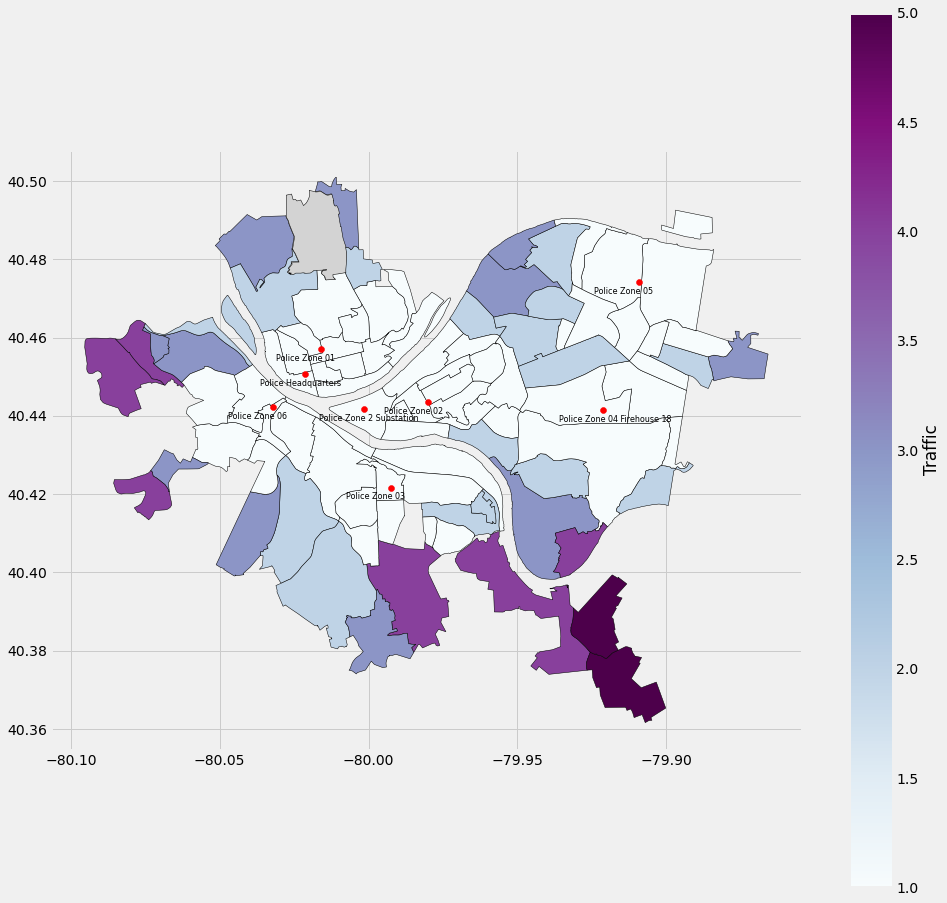

In [10]:
dis_map = neighborhoods.merge(avgDis, how='left', left_on='hood', right_on='neighborhood')

#Plotting the map 
fig, ax = plt.subplots(figsize = (15, 15))
dis_map.plot(ax = ax, column='distance', 
               cmap='BuPu',              
               edgecolor="black",        
               legend=True,              
               legend_kwds={'label': "Traffic"}, 
               figsize=(15, 15),        
               missing_kwds={"color": "lightgrey"} 
)

#Adds dots to map
plt.scatter(x=police["longitude"], y=police["latitude"], color="red", marker="o")

#Adds labels to police stations 
for i, police_station in police.iterrows():
    plt.text(police_station["longitude"] -0.015, police_station["latitude"]-0.003, police_station["name"], fontsize=8, color="black")

First lets read in the Arrest data and sort it by Incident Neighborhoods.

In [11]:
arrest_data = pd.read_csv("Arrests.csv", usecols = ["INCIDENTNEIGHBORHOOD"])
arrest_data.dropna(inplace=True)
arrest_data.head(10)

,INCIDENTNEIGHBORHOOD
0,Bloomfield
1,Outside City
2,Westwood
3,East Allegheny
4,Crafton Heights
5,Greenfield
6,Brookline
7,Regent Square
8,East Liberty
10,East Hills


Next lets read in population data, drop all the N/A values, and sort all the 2020 total neighborhood population values from greatest to least values.

In [12]:
population_data = pd.read_csv("Population.csv", usecols = ["2020_Total_Population", "Neighborhood"])
population_data.dropna(inplace=True)
population_data.head(10)
population_data.sort_values(by= "2020_Total_Population", ascending = False)

,Neighborhood,2020_Total_Population
66,Shadyside,15317
75,Squirrel Hill South,15317
12,Brookline,13063
74,Squirrel Hill North,11879
54,North Oakland,10691
...,...,...
55,North Shore,301
85,West End,205
76,St. Clair,183
69,South Shore,29


Next I made a list that has the name of the neighborhood, the population in 2020, and the number of incidents that occured.

In [13]:
data_combined = arrest_data.merge(population_data, how = "left", left_on = "INCIDENTNEIGHBORHOOD", right_on = "Neighborhood")
data_combined.dropna(inplace = True)
data_combined.drop("INCIDENTNEIGHBORHOOD", axis = 1, inplace = True)
data_combined.iloc[0:]
data_combined.sort_values(by= "2020_Total_Population", ascending = False)
data_combined2 = data_combined.groupby("Neighborhood").size()
data_combined2.sort_values (ascending = False)
data_combined = data_combined.merge(data_combined2.to_frame(), how = "left", left_on = "Neighborhood", right_on = "Neighborhood")
data_combined.drop_duplicates(inplace = True)
data_combined.head()
data_combined.sort_values(by= [0], ascending = False)
data_combined = data_combined.rename(columns = {data_combined.columns[2]:"Incidents"})
print (data_combined)

         Neighborhood  2020_Total_Population  Incidents
0          Bloomfield                 8665.0        880
1            Westwood                 3332.0        203
2      East Allegheny                 1903.0       1893
3     Crafton Heights                 3999.0        513
4          Greenfield                 7261.0        473
...               ...                    ...        ...
1670    New Homestead                  917.0         38
1795        Ridgemont                  390.0         32
2007   Swisshelm Park                 1339.0         38
2131             Hays                  321.0         98
3144   Chartiers City                  492.0         38

[85 rows x 3 columns]


Here I divided the population by the number of incidents to get the ratio of people to arrests.

In [14]:
data_combined["Ratio"] = data_combined["2020_Total_Population"].div(data_combined["Incidents"])
print (data_combined)

         Neighborhood  2020_Total_Population  Incidents      Ratio
0          Bloomfield                 8665.0        880   9.846591
1            Westwood                 3332.0        203  16.413793
2      East Allegheny                 1903.0       1893   1.005283
3     Crafton Heights                 3999.0        513   7.795322
4          Greenfield                 7261.0        473  15.350951
...               ...                    ...        ...        ...
1670    New Homestead                  917.0         38  24.131579
1795        Ridgemont                  390.0         32  12.187500
2007   Swisshelm Park                 1339.0         38  35.236842
2131             Hays                  321.0         98   3.275510
3144   Chartiers City                  492.0         38  12.947368

[85 rows x 4 columns]


Then I sorted the ratio values from greatest to least.

In [15]:
data_combined.sort_values(by= "Ratio", ascending = False)

,Neighborhood,2020_Total_Population,Incidents,Ratio
34,Central Northside,2972.0,23,129.217391
467,Squirrel Hill North,11879.0,252,47.138889
2007,Swisshelm Park,1339.0,38,35.236842
6,Regent Square,971.0,32,30.343750
255,North Oakland,10691.0,390,27.412821
...,...,...,...,...
72,Homewood West,642.0,699,0.918455
205,West End,205.0,250,0.820000
26,North Shore,301.0,722,0.416898
144,South Shore,29.0,268,0.108209


I did the same but from least to greatest.

In [16]:
data_combined.sort_values(by= "Ratio", ascending = True)

,Neighborhood,2020_Total_Population,Incidents,Ratio
183,Chateau,19.0,393,0.048346
144,South Shore,29.0,268,0.108209
26,North Shore,301.0,722,0.416898
205,West End,205.0,250,0.820000
72,Homewood West,642.0,699,0.918455
...,...,...,...,...
255,North Oakland,10691.0,390,27.412821
6,Regent Square,971.0,32,30.343750
2007,Swisshelm Park,1339.0,38,35.236842
467,Squirrel Hill North,11879.0,252,47.138889


Finally, I graphed both ratios on bar graphs for neighborhoods with the highest 10 ratios and neighborhoods with the lowest 10 ratios. Here we can see what neighborhoods to avoid hiding a dead body in and which ones we should be considering hiding a body in. The neighborhoods with the highest ratios would be the best, and the lowest would be the worst.

[Text(0, 0, 'Chateau'),
 Text(0, 0, 'South Shore'),
 Text(0, 0, 'North Shore'),
 Text(0, 0, 'West End'),
 Text(0, 0, 'Homewood West'),
 Text(0, 0, 'East Allegheny'),
 Text(0, 0, 'Homewood South'),
 Text(0, 0, 'Allegheny Center'),
 Text(0, 0, 'Homewood North'),
 Text(0, 0, 'Fineview')]

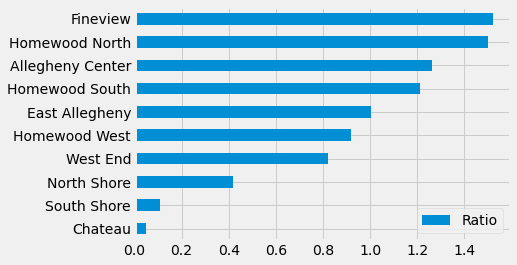

In [17]:
data_combined3 = data_combined.loc[:,["Neighborhood", "Ratio"]]
data_combined3.sort_values(inplace = True, by = "Ratio")
data_combined3.head()
data_combined3[:10].plot.barh().set_yticklabels(data_combined3.Neighborhood)

In [18]:
data_combined3 = data_combined.loc[:,["Neighborhood", "Ratio"]]
data_combined3.sort_values(inplace = True, by = "Ratio", ascending = False)
data_combined3.head()
#data_combined3[:10].plot.barh().set_yticklabels(data_combined3.Neighborhood)

,Neighborhood,Ratio
34,Central Northside,129.217391
467,Squirrel Hill North,47.138889
2007,Swisshelm Park,35.236842
6,Regent Square,30.343750
255,North Oakland,27.412821


In [19]:
traffic_new = pd.DataFrame(num_traffic)
traffic_new.iloc[0] = traffic_new.iloc[0].rename("column2")
traffic_new.iloc[1] = traffic_new.iloc[1].rename("column2")


traffic_new.head(10)

,average_daily_car_traffic
neighborhood,
Allegheny Center,2386.000000
Allegheny West,477.000000
Arlington,2285.500000
Beechview,1418.333333
Beltzhoover,1577.000000
Bloomfield,3078.642857
Bluff,1788.333333
Brighton Heights,2515.666667
Brookline,3914.400000


Now to combine all the metrics and to detirmine the best neighborhood.

In [71]:
final_df = pd.merge(data_combined3, avgDis,  how='left', left_on="Neighborhood", right_on = "neighborhood")
final_df = pd.merge(final_df, num_traffic,  how='left', left_on="Neighborhood", right_on = "neighborhood")
final_df.dropna(inplace=True)
final_df.drop(columns = "neighborhood", inplace = True)
final_df['Final_metric'] = final_df['Ratio']/1.5 - final_df['average_daily_car_traffic']/500 + final_df["distance"]*20

print(final_df)

                Neighborhood       Ratio  distance  average_daily_car_traffic  \
0          Central Northside  129.217391       1.0                1189.000000   
1        Squirrel Hill North   47.138889       1.0                3939.111111   
3              Regent Square   30.343750       1.0               16729.000000   
4              North Oakland   27.412821       1.0                5955.250000   
5              New Homestead   24.131579       5.0                 666.000000   
6            Stanton Heights   22.246231       2.0                4068.000000   
7        Squirrel Hill South   21.068776       1.0                3050.076923   
8               Point Breeze   18.897527       1.0                3905.250000   
9                Morningside   18.797688       1.0                2049.285714   
10                 Shadyside   17.914620       2.0                4408.800000   
11             Lincoln Place   16.605263       5.0                 126.000000   
12                  Westwood

[Text(0, 0, 'New Homestead'),
 Text(0, 0, 'Lincoln Place'),
 Text(0, 0, 'Windgap'),
 Text(0, 0, 'Central Northside'),
 Text(0, 0, 'Carrick'),
 Text(0, 0, 'Summer Hill'),
 Text(0, 0, 'Overbrook'),
 Text(0, 0, 'Central Lawrenceville'),
 Text(0, 0, 'Chartiers City'),
 Text(0, 0, 'Hazelwood')]

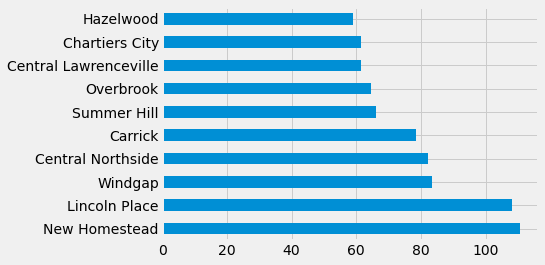

In [70]:
final_df.sort_values(inplace = True, by = "Final_metric", ascending = False)
final_df.Final_metric.sort_values(ascending = False)[:10].plot.barh().set_yticklabels(final_df.Neighborhood)

## Conclusions

##### Harrison:
    
##### Matt: